**Detection, Segmentation, and 3D Pose Estimation of Surgical Tools Using Deep Convolutional Neural Networks and Algebraic Geometry**

Article link: https://www.sciencedirect.com/science/article/abs/pii/S1361841521000402


We present a Single Input Multiple Output Deep Convolution Neural Network(SIMO-DCNN) to get concurrent outputs, trained in an end-to-end fashion. The concurrent outputs are:

&emsp; &emsp; &emsp; 1. Detection sub-network for the tool presence identification.  <br>
&emsp; &emsp; &emsp; 2. Segmentation sub-network for getting the surgical instrument masks.  <br>
&emsp; &emsp; &emsp; 3. Regression sub-network-1 for edgeLine (tool boundary) extraction.  <br>
&emsp; &emsp; &emsp; 4. Regression sub-network-2 for midLine extraction. <br>
&emsp; &emsp; &emsp; 5. Regression sub-network-3 for toolTip extraction.  <br>



* This code is written by 
        ** Md. Kamrul Hasan 
        ** Medical Imaging and Applications (MAIA)
        ** Erasmus Scholar [2017-2019] 
        ** Contact: kamruleeekuet@gmail.com

## Import Packages 

In [1]:
import numpy as np
import os
import cv2

from comet_ml import Experiment
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras import backend as keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import plot_model, to_categorical
from keras.models import model_from_yaml

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import cv2
import glob
import itertools
import skimage.io as io
import skimage.transform as trans
from keras.initializers import Constant

from matplotlib import pyplot as plt
%matplotlib inline

from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_score



experiment = Experiment("uZNKTZZcJmpNzL5fR63ExATlm",
    project_name="Rafal_test",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True)


Using TensorFlow backend.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/simongeek/rafal-test/695dfcecb2474a749f9c037288baefd0



## Implementation of Proposed Architecture

In [2]:
'''
The implementation details with the explanation can be found on the paper. 
Please, read the paper first then see the source code.
'''
def SIMOCNN(nClasses, input_height, input_width):
    
    '''
    Load VGG16 from keras and initialize with the ImageNet. The output of the VGG16
    which is pool5 is used as input to all the sub-networks. This part of the network
    is responsible for the feature extraction which is so called convolution part 
    of the semantic segmentation CNN. 
    '''
    
    # defining the Input shape where channel 3 means RGB.  
    img_input = Input(shape=(input_height, input_width, 3)) 

    vgg_Base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_tensor = img_input) 
    
    '''
    To overcome the sub-sampling limitations  and  deconvolution  overlap, we  have
    employed two types of skip connections. First one is between the corresponding
    same dimensional feature map in both encoder and decoder which  has  ladder like
    structure and  it  is  inspired  from  U-Net. Second  one, so called FrG connect
    the very end layer of the decoder with the original image via stack of depthwise
    separable  convolution  without sub-sampling  to  produce  the  fully resolution
    feature map. Second skip connection is the compensatory of losing spacial 
    information dueto sub-sampling by concatenating the full resolution feature map.  
    In the presented SIMO-DCNN network, both  the  segmentation  and  regression  
    sub-networks  follow  our proposedencoder-decoder  networks  to  get  full  
    resolution  features  map.
    '''
    
    
    FrG = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(img_input)
    FrG = BatchNormalization()(FrG)
    
    FrG = SeparableConv2D(filters = 256,
                          kernel_size = (3, 3),
                          activation = 'relu', 
                          kernel_initializer='glorot_uniform', 
                          padding="same")(FrG)
    FrG = BatchNormalization()(FrG)
        
    FrG = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(FrG)
    FrG = BatchNormalization()(FrG)
    
    FrG = SeparableConv2D(filters = nClasses,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(FrG)
    FrG = BatchNormalization()(FrG)
    
    
    '''
    Decoding the encoded output to semantically project the discriminating features 
    of  lower  resolution learnt  by  the  encoder  onto  the  pixel space  of 
    higher  resolution  to  get a dense pixel wise classification.
    '''
    
    
    conv_14 = SeparableConv2D(filters = 1024, 
                            kernel_size = (3, 3), 
                            activation = 'relu', 
                            kernel_initializer='glorot_uniform', 
                            padding="same")(vgg_Base.output)
    conv_14 = BatchNormalization()(conv_14)


    conv_15 = SeparableConv2D(filters = 1024, 
                              kernel_size = (3, 3), 
                              activation = 'relu', 
                              kernel_initializer='glorot_uniform', 
                              padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)

    
    deconv_1 = UpSampling2D(size = (2, 2))(conv_15)
    deconv_1 = concatenate([vgg_Base.get_layer(name="block4_pool").output,
                            deconv_1], axis=-1)
    deconv_1 = SeparableConv2D(filters = 512, 
                               kernel_size = (3, 3), 
                               activation = 'relu', 
                               kernel_initializer='glorot_uniform', 
                               padding = "same")(deconv_1)
    deconv_1 = BatchNormalization()(deconv_1)


    deconv_2 = UpSampling2D(size = (2, 2))(deconv_1)
    deconv_2 = concatenate([vgg_Base.get_layer(name="block3_pool").output,
                            deconv_2], axis=-1)
    deconv_2 = SeparableConv2D(filters = 256,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(deconv_2)
    deconv_2 = BatchNormalization()(deconv_2)


    deconv_3 = UpSampling2D( size = (2, 2))(deconv_2)
    deconv_3 = concatenate([vgg_Base.get_layer(name="block2_pool").output,
                            deconv_3], axis=-1)
    deconv_3 = SeparableConv2D(filters = 128,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(deconv_3)
    kept = BatchNormalization()(deconv_3)
    
    
    

    '''
    DBRS blocks named as segmentation sub-network for semantic tissue or
    instrument pixels labelling to get semantic segmentation of the surgical tool.
    '''
    
    tool = UpSampling2D(size = (2, 2))(kept)
    tool = concatenate([vgg_Base.get_layer( name="block1_pool").output, 
                        tool], axis=-1)
    
    tool = SeparableConv2D(filters = 64,
                           kernel_size = (3, 3), 
                           activation = 'relu',
                           kernel_initializer='glorot_uniform',
                           padding = "same")(tool)
    tool = BatchNormalization()(tool)

    tool = UpSampling2D(size = (2, 2))(tool)
    tool = SeparableConv2D(filters = 64, 
                           kernel_size = (3, 3), 
                           activation = 'relu',
                           kernel_initializer='glorot_uniform', 
                           padding = "same")(tool)
    tool = BatchNormalization()(tool)

    tool = SeparableConv2D(filters = nClasses,
                           kernel_size = (1, 1),
                           activation = 'relu',
                           kernel_initializer='glorot_uniform',
                           padding = "same")(tool)
    tool = BatchNormalization()(tool)

    tool = concatenate([tool, FrG], axis=-1)

    tool = Conv2D(filters = 1,
                  kernel_size = 1,
                  activation = 'sigmoid',
                  name='tool')(tool)
 
    modeltool = Model(input = img_input, output = tool)    
    #modeltool.load_weights('PreTrainedModel.hdf5')
    
    
    
    '''
    DBR blocks named as regression sub-network for mid-line feature of the surgical
    tool for pose estimation. 
    '''

    midline = UpSampling2D(size = (2, 2))(kept)
    midline = concatenate([vgg_Base.get_layer( name="block1_pool").output, 
                           midline], axis=-1)
    
    midline = SeparableConv2D(filters = 64,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(midline)
    midline = BatchNormalization()(midline)

    midline = UpSampling2D(size = (2, 2))(midline)
    midline = SeparableConv2D(filters = 64, 
                              kernel_size = (3, 3),activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(midline)
    midline = BatchNormalization()(midline)

    midline = SeparableConv2D(filters = nClasses, 
                              kernel_size = (1, 1),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(midline)
    midline = BatchNormalization()(midline)

    midline = concatenate([midline, FrG], axis=-1)

    midline = Conv2D(filters = 1,
                     kernel_size = 1,
                     activation = 'sigmoid',
                     name='midline')(midline)
 
    modelmidline = Model(input = img_input, output = midline)    
    #modelmidline.load_weights('PreTrainedModel.hdf5')
 


    '''
    DBR blocks named as regression sub-network for tool-tip feature of the surgical
    tool for pose estimation. 
    '''

    tooltip = UpSampling2D(size = (2, 2))(kept)
    tooltip = concatenate([vgg_Base.get_layer( name="block1_pool").output,
                           tooltip], axis=-1)
    
    tooltip = SeparableConv2D(filters = 64,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(tooltip)
    tooltip = BatchNormalization()(tooltip)

    tooltip = UpSampling2D(size = (2, 2))(tooltip)
    tooltip = SeparableConv2D(filters = 64,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(tooltip)
    tooltip = BatchNormalization()(tooltip)

    tooltip = SeparableConv2D(filters = nClasses,
                              kernel_size = (1, 1),
                              activation = 'relu', 
                              kernel_initializer='glorot_uniform', 
                              padding = "same")(tooltip)
    tooltip = BatchNormalization()(tooltip)

    tooltip = concatenate([tooltip, FrG], axis=-1)

    tooltip = Conv2D(filters = 1,
                     kernel_size = 1,
                     activation = 'sigmoid',
                     name='tooltip')(tooltip)
 
    modeltooltip = Model(input = img_input, output = tooltip)    
    #modeltooltip.load_weights('PreTrainedModel.hdf5')
    
    
    '''
    DBR blocks named as regression sub-network for Edge-line feature of the surgical
    tool for pose estimation. 
    '''

    edgeline = UpSampling2D(size = (2, 2))(kept)
    edgeline = concatenate([vgg_Base.get_layer( name="block1_pool").output,
                            edgeline], axis=-1)
    
    edgeline = SeparableConv2D(filters = 64,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(edgeline)
    edgeline = BatchNormalization()(edgeline)

    edgeline = UpSampling2D(size = (2, 2))(edgeline)
    edgeline = SeparableConv2D(filters = 64,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(edgeline)
    edgeline = BatchNormalization()(edgeline)

    edgeline = SeparableConv2D(filters = nClasses,
                               kernel_size = (1, 1),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(edgeline)
    edgeline = BatchNormalization()(edgeline)

    edgeline = concatenate([edgeline, FrG], axis=-1)

    edgeline = Conv2D(filters = 1,
                      kernel_size = 1,
                      activation = 'sigmoid',name='edgeline')(edgeline)
 
    modeledgeline = Model(input = img_input, output = edgeline)    
    #modeledgeline.load_weights('PreTrainedModel.hdf5')


    '''
    Detection sub-network for getting the tool flag that will indicate 
    either pose will estimate or not? 
    '''
    x = modeltool.get_layer('block5_conv3').output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax',name='detection')(x)
    
    modeldetection = Model(inputs=img_input, outputs=x)
    

    '''
    SIMO model is build by returning the multiple output as a list variable. 
    In the output prediction the sequence of the outputs are as follows:
    
    Output[0]= Predicted Probabilty map fo the surgical tool segmentation.
    Output[1]= Predicted Regression map for the mid-line of the surgical tool.
    Output[2]= Predicted Regression map for the tool-tip of the surgical tool.
    Output[3]= Predicted Regression map for the edge-line of the surgical tool.
    Output[4]= Predicted softmax probability of the tool detection.
    '''
      
    SIMO = Model(input = img_input, output = [modeltool.output,
                                              modelmidline.output,
                                              modeltooltip.output,
                                              modeledgeline.output,
                                              modeldetection.output])
    
#     for layer in SIMO.layers[:40]:
#         layer.trainable = False    

    return SIMO

## Data Generator function for the batch-by-batch Training

In [3]:
def DataGenerator(data, batch_size): 
    '''
    This function is for the data generator for fit_generator training of the SIMO
    model. 
    Input Argument: 
          data = Is the numpy array having 6 column and N row. N is the number of 
          images as training/ testing sample. It can be pressented as below-
          
          orgImage | tool mask | edge-line | mid-line | tool-tip | label |
          ---------|-----------|-----------|----------|----------|-------|
          
          ---------|-----------|-----------|----------|----------|-------|
          batch_size = the number of samples that will perform forward-backward pass
                       in a single shot.
    Output Argument:
        Tuple of the true images and corresponding mask/ label for each types
        of sub-network. 
    '''
    
    img = np.array([i[0] for i in data]).reshape(-1,192,256,3)
    mask = np.array([i[1] for i in data]).reshape(-1,192,256,1)
    edge = np.array([i[2] for i in data]).reshape(-1,192,256,1)
    mid  = np.array([i[3] for i in data]).reshape(-1,192,256,1)
    tip = np.array([i[4] for i in data]).reshape(-1,192,256,1)
    label = np.array([i[5] for i in data])
    
    label=to_categorical(label, num_classes=2, dtype='float32')

    zipped = itertools.cycle( zip(img, mask, mid, edge, tip, label))
    

    while True:
        X = [] 
        Y = []
        Z = []
        A = []
        C = []   
        D = []
        for _ in range( batch_size):
            im , sg, sg_mid, sg_edge, sg_tip, lab = next(zipped)
            X.append(im)
            Y.append(sg)
            Z.append(sg_mid)
            A.append(sg_edge)
            C.append(sg_tip)
            D.append(lab)
            
        yield (np.array(X) , {'tool':np.array(Y),
                              'midline':np.array(Z),
                              'tooltip':np.array(C),
                              'edgeline':np.array(A),
                              'detection':np.array(D)})

## Loss function

In [4]:
def IoU(y_true, y_pred):
        
    ''' 
    The Intersection over Union (IoU) also referred to as the Jaccard index (JI),
    is essentially a method to quantify the percent overlap between the GT mask
    and prediction output. The IoU metric measures the number of pixels common 
    between the target and prediction masks divided by the total number of pixels
    present across both masks.
  
    Input Arguments: 
        y_true: True Labels of the 2D images so called ground truth (GT).
        y_pred: Predicted Labels of the 2D images so called Predicted/ segmented Mask.
        
    Output Arguments: 

        iou: The IoU between y_true and y_pred

    Author: Md. Kamrul Hasan, 
            Erasmus Scholar on Medical Imaging and Application (MAIA)
            E-mail: kamruleeekuet@gmail.com

    '''
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)-intersection)


def IoU_loss(y_true, y_pred):
    return 1-IoU(y_true, y_pred)


def bce_IoU_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + IoU_loss(y_true, y_pred))

## Train the whole SIMO end-to-end fashion

In [5]:
class Datacb(Callback):
    def __init__(self, experiment, sample):
        self.experiment = experiment
        self.sample = sample
    def on_epoch_end(self, epoch, logs={}):
        res = self.model.predict(np.expand_dims(self.sample[0],0))
        plt.figure();
        plt.imshow(np.squeeze(res[0]))
        plt.title("return mask")
        self.experiment.log_figure(figure=plt)
        plt.figure();
        plt.imshow(self.sample[0])
        plt.title('test plot data')
        self.experiment.log_figure(figure=plt)
        plt.figure();
        plt.imshow(self.sample[1])
        plt.title('test plot mask')
        self.experiment.log_figure(figure=plt)

        
        

        

2022-05-23 19:08:43.368998: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-23 19:08:43.401971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2022-05-23 19:08:43.402289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-23 19:08:43.404359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-23 19:08:43.406272: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-23 19:08:43.406667: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/1


COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations
2022-05-23 19:09:12.436554: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-23 19:09:12.694027: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


  1/133 [..............................] - ETA: 40:09 - loss: 3.3725 - tool_loss: 1.7524 - midline_loss: 0.3265 - tooltip_loss: 0.3130 - edgeline_loss: 0.2702 - detection_loss: 0.7105 - tool_IoU: 0.0300 - midline_mae: 0.5260 - tooltip_mae: 0.5055 - edgeline_mae: 0.4780 - detection_acc: 0.6000

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


133/133 [==============================] - 108s 809ms/step - loss: 3.2269 - tool_loss: 1.5829 - midline_loss: 0.1804 - tooltip_loss: 0.1589 - edgeline_loss: 0.1667 - detection_loss: 1.1381 - tool_IoU: 0.0148 - midline_mae: 0.4096 - tooltip_mae: 0.3766 - edgeline_mae: 0.3806 - detection_acc: 0.5038 - val_loss: 2.4883 - val_tool_loss: 1.4806 - val_midline_loss: 0.1386 - val_tooltip_loss: 0.0923 - val_edgeline_loss: 0.0874 - val_detection_loss: 0.6927 - val_tool_IoU: 0.0178 - val_midline_mae: 0.3717 - val_tooltip_mae: 0.3037 - val_edgeline_mae: 0.2893 - val_detection_acc: 0.5032


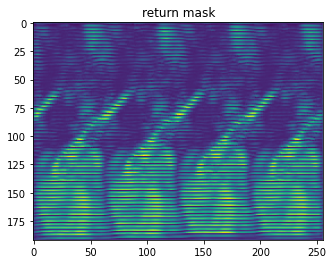

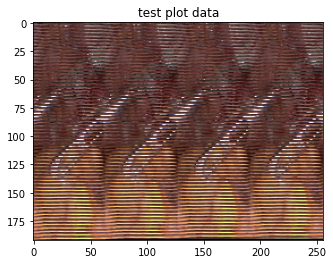

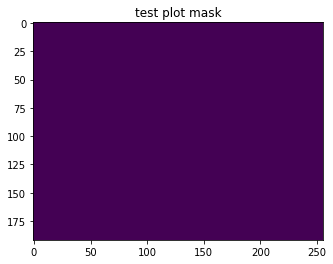

In [6]:
CurrentDirectory=os.getcwd()


datatrain = np.load(CurrentDirectory+'/training_data.npy', allow_pickle=True)
TrainGen = DataGenerator(data= datatrain, batch_size=5)


datatest = np.load(CurrentDirectory+'/testing_data.npy', allow_pickle=True)


TestGen = DataGenerator(data= datatest, batch_size=5)
VisGen = DataGenerator(data = datatest, batch_size=1)
samples = next(TestGen)
sample = (samples[0][0,...], samples[1]['tool'][0,...])

model = SIMOCNN(2, 192, 256)


#plot_model(model, show_shapes=True, to_file='Graph of ART-Net.png')
model.summary()


model.compile(optimizer = 'adadelta', 
              loss = {'tool':bce_IoU_loss,
                      'midline':'mean_squared_error',
                      'tooltip':'mean_squared_error',
                      'edgeline':'mean_squared_error',
                      'detection':'categorical_crossentropy',}, 
              metrics = {'tool': IoU,
                         'midline':'mae',
                         'tooltip':'mae',
                         'edgeline':'mae',
                         'detection': 'acc'})

#model_checkpoint = ModelCheckpoint('FineTunedmodel.hdf5', 
#                                  monitor='val_loss', 
#                                   verbose=1, 
#                                   save_best_only=True)

from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log.csv', append=False, separator=';')
datacb = Datacb(experiment, sample)

model_yaml = model.to_yaml()
with open('modelSaved.yaml', "w") as yaml_file:
    yaml_file.write(model_yaml)

with experiment.train():
    history=model.fit_generator(TrainGen, 
                                steps_per_epoch=133, 
                                epochs=1,
    #                            epochs=1,
                                verbose=1, 
                                validation_data= TestGen, 
                                validation_steps=31,
                                callbacks=[csv_logger, datacb],
    #                            callbacks=[model_checkpoint],
                                use_multiprocessing=True)


## Plot the training and testing performance of the SIMO

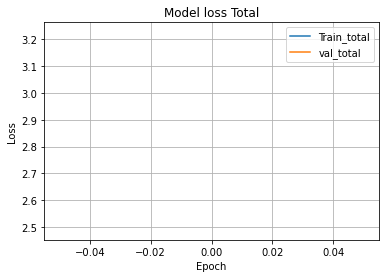

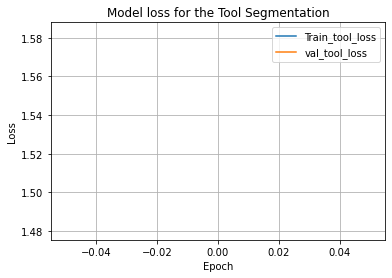

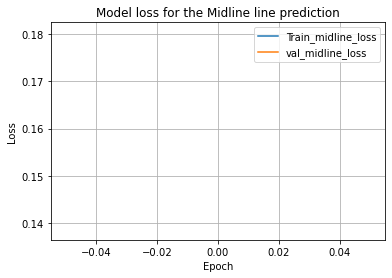

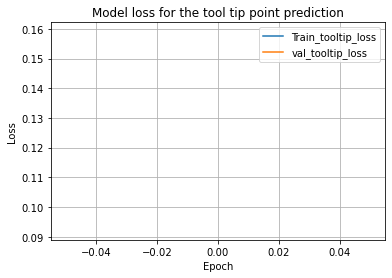

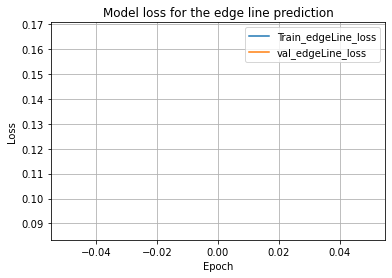

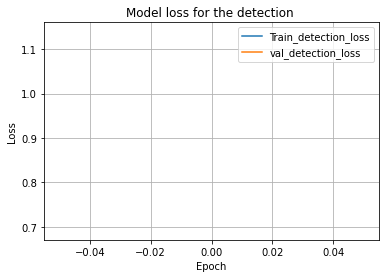

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/simongeek/rafal-test/695dfcecb2474a749f9c037288baefd0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_batch_detection_acc [14]    : (0.46666666865348816, 0.6000000238418579)
COMET INFO:     train_batch_detection_loss [14]   : (0.7104765772819519, 5.241415977478027)
COMET INFO:     train_batch_edgeline_loss [14]    : (0.16791725158691406, 0.2701883614063263)
COMET INFO:     train_batch_edgeline_mae [14]     : (0.38210734724998474, 0.4779672622680664)
COMET INFO:     train_batch_loss [14]             : (2.3860278129577637, 3.372471570968628)
COMET INFO:     train_batch_midline_loss [14]     : (0.18168719112873077, 0.32645368576049805)
COMET INFO:     train_batch_midline_mae [14]      : (0.4111713767051697, 0.5259515047073364)
COMET I

In [7]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_total','val_total'], loc='upper right')
plt.grid('on')
#plt.savefig('total_loss')
plt.show()


plt.figure()
plt.plot(history.history['tool_loss'])
plt.plot(history.history['val_tool_loss'])
plt.title('Model loss for the Tool Segmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_tool_loss', 'val_tool_loss'], loc='upper right')
plt.grid('on')
plt.grid('on')
#plt.savefig('tool_loss')
plt.show()


plt.figure()
plt.plot(history.history['midline_loss'])
plt.plot(history.history['val_midline_loss'])
plt.title('Model loss for the Midline line prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_midline_loss','val_midline_loss'], loc='upper right')
plt.grid('on')
#plt.savefig('midline_loss')
plt.show()


plt.figure()
plt.plot(history.history['tooltip_loss'])
plt.plot(history.history['val_tooltip_loss'])
plt.title('Model loss for the tool tip point prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_tooltip_loss','val_tooltip_loss'], loc='upper right')
plt.grid('on')
#plt.savefig('tooltip_loss')
plt.show()


plt.figure()
plt.plot(history.history['edgeline_loss'])
plt.plot(history.history['val_edgeline_loss'])
plt.title('Model loss for the edge line prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_edgeLine_loss','val_edgeLine_loss'], loc='upper right')
plt.grid('on')
#plt.savefig('edgeline_loss')
plt.show()


plt.figure()
plt.plot(history.history['detection_loss'])
plt.plot(history.history['val_detection_loss'])
plt.title('Model loss for the detection ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_detection_loss','val_detection_loss'], loc='upper right')
plt.grid('on')
#plt.savefig('detection_loss')
plt.show()
experiment.end()